[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


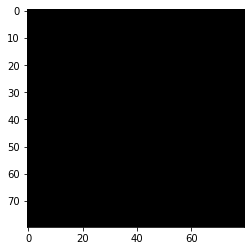

Time:  5.313076199999999 seconds


In [1]:
# Numerical computation of an X-ray scanner using Monte Carlo techniques

import timeit    
start = timeit.default_timer()
from random import random
import random 
import matplotlib.pyplot as plt
import numpy as np
import math

# Diff. values in the Room define objects: 0 = walls, 1 = inside room, 2 = patient's tissue, 3 = bone, 4 = x-ray detector

Room = np.array([[[0.0 for i in range(0,101,1)] for j in range(0,101,1)] for k in range(0,101,1)]) #The entire room with walls

for i in range(1,100,1):
    for j in range(1,100,1):
        for k in range(1,100,1):
            Room[i,j,k] +=1     # The room not counting the walls = '1'

for i in range(30,70,1):
    for j in range(30,70,1):
        for k in range(30,70,1):
            Room[i,j,k] +=1      #The patient's body (tissue) '2'
            
for i in range(50,55,1):
    for j in range(50,55,1):
        for k in range(50,55,1):
            Room[i,j,k] +=1      #The patient's bone #1 = '3'
            
for i in range(58,63,1):
    for j in range(58,63,1):
        for k in range(58,63,1):
            Room[i,j,k] +=1      #The patient's bone #2 = '3'

for i in range(88,92,1):
    for j in range(10,90,1):
        for k in range(10,90,1):
            Room[i,j,k] +=3      # X-ray Detector = '4'
            
            

N_Xrays_emitted = [10**3, 10**4, 10**5, 10**6, 10**7] #just possible 'settings' - number of x-rays to emmit overall

PossibleUnitDirections = np.array([0, 1,-1])

PossibleEnergies = [30,40,50,60,80,100] #Possible energies from 30-100keV available at https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/water.html

# X-ray energy [kev] : mass attentuation coefficient mu/rho [cm^2/g] available from https://physics.nist.gov/PhysRefData
MassAttenuationCoeffs_Water_ie_Tissue = { 
  30 : 0.3756,
  40 : 0.2683,
  50 : 0.2269,
  60 : 0.2059,
  80 : 0.1837,
  100 : 0.1707
}  # from https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/water.html
MassAttenuationCoeffs_Bone = {
  30 : 1.331,
  40 : 0.6644,
  50 : 0.4242,
  60 : 0.3148,
  80 : 0.2229,
  100 : 0.1855
}  # from https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html       
MassAttenuationCoeffs_Silicon_ie_Detector = {
  30 : 1.436,
  40 : 0.7012,
  50 : 0.4385,
  60 : 0.3207,
  80 : 0.2228,
  100 : 0.1835
}  # from https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z14.html                          

Detector = np.array([[0.0 for j in range(10,90,1)] for k in range(10,90,1)])
                            
for N in range(N_Xrays_emitted[0]): #just choosing one of the possible number emitted x-rays defined earlier
    alive = True
    Xray_position = [10,50,50] # Each X-ray starts here from a point source
    Xray_direction = [1,random.choice(PossibleUnitDirections)*random.random(),random.choice(PossibleUnitDirections)*random.random()]
    Xray_Energy = random.choice(PossibleEnergies)  # results in a flat x-ray energy distribution 
    
    while alive==True: # The photon is "alive" i.e. not absorbed yet
        for i in range(len(Xray_position)):
            Xray_position[i] = Xray_position[i] + Xray_direction[i] #changing x-ray position in the random direction component by component
            
            if Xray_position[i] > 100:
                alive = False
                break
            if Room[round(Xray_position[0]),round(Xray_position[1]),round(Xray_position[2])] == 0:  
                alive = False # Photon got absorbed in the wall or beyond the room
                break 
    
            if Room[round(Xray_position[0]),round(Xray_position[1]),round(Xray_position[2])] == 1: # Just within the room
                continue
            
            if Room[round(Xray_position[0]),round(Xray_position[1]),round(Xray_position[2])] == 2: # Tissue hit
                
                mu_over_rho = MassAttenuationCoeffs_Water_ie_Tissue[Xray_Energy] # [cm^2/g]
                rho = 1 # density of water i.e. tissue [g/cm^3]
                
                # absorbed prob = 1-exp(-mu/rho *rho * dx) where dx is the step size, length of vector Xray_direction
                Absorption_Probability = 1-math.exp(-mu_over_rho*rho*math.sqrt(Xray_direction[0]**2+Xray_direction[1]**2+Xray_direction[2]**2))
                
                Absorption_orNot = random.random()-Absorption_Probability # so the greater the prob. of absorp. the more likely Absorption_orNot becomes negative = absorption.
                if Absorption_orNot > 0:
                    continue
                else: 
                    alive=False
                    break
            
            if Room[round(Xray_position[0]),round(Xray_position[1]),round(Xray_position[2])] == 3: # Bone hit
                
                mu_over_rho = MassAttenuationCoeffs_Bone[Xray_Energy]  # [cm^2/g]
                rho = 0.9 # Osteoporosis-bordering density of bone [g/cm^3] (normal is 0.92-1.35)
                Absorption_Probability = 1-math.exp(-mu_over_rho*rho*math.sqrt(Xray_direction[0]**2+Xray_direction[1]**2+Xray_direction[2]**2))
                
                Absorption_orNot = random.random()-Absorption_Probability # so the greater the prob. of absorp. the more likely Absorption_orNot becomes negative = absorption.
                if Absorption_orNot > 0:
                    continue
                else: 
                    alive=False
                    break
                
            if Room[round(Xray_position[0]),round(Xray_position[1]),round(Xray_position[2])] == 4: # Detector hit!
                
                mu_over_rho = MassAttenuationCoeffs_Silicon_ie_Detector[Xray_Energy] # [cm^2/g]
                rho = 2.33 # density of silicon i.e. the x-ray detector [g/cm^3]
                Absorption_Probability = 1-math.exp(-mu_over_rho*rho*math.sqrt(Xray_direction[0]**2+Xray_direction[1]**2+Xray_direction[2]**2))
                
                Absorption_orNot = random.random()-Absorption_Probability # so the greater the prob. of absorp. the more likely Absorption_orNot becomes negative = absorption.
                if Absorption_orNot > 0:
                    continue  # photon didn't get absorbed
                else: 
                    alive=False  # photon got absorbed and detected
                    
                    Detector[round(Xray_position[1]),round(Xray_position[2])] += 1 #store x and z coordinate of where x-ray hit the detector
                    
                    break

print(Detector)
plt.imshow(Detector, cmap="gray") # much easier than the histogram
plt.show()
"""
y_array = [Detector[j,:] for j in range(Detector)] ???? not making these arrays properly.
z_array = [Detector[:,k] for k in range(Detector)] ???? 

plt.hist2d(y_array, z_array, bins=(100,100), cmap = 'Greys') 
"""


stop = timeit.default_timer()
print('Time: ', stop - start, "seconds")  